# Grammar Scoring Engine

This notebook implements a machine learning model to predict grammar scores (0-5) from spoken audio samples.

## Table of Contents
1. Setup and Dependencies
   - Environment configuration
   - Required packages
   - API setup
2. Audio Processing and Grammar Analysis Functions
   - Speech-to-text conversion
   - Grammar analysis pipeline
   - Error handling
3. Process Training Data and Evaluate
   - Data loading
   - Batch processing
   - Intermediate results
   - Performance metrics
4. Model Development
   - Architecture design
   - Training process
   - Hyperparameter tuning
4. Predictions and Submission
   - Test set processing
   - Score generation
   - Submission format

## 1. Setup and Dependencies

In [7]:
import logging
import os
import json
import numpy as np
import pandas as pd
from groq import Groq
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO)

# Check for Groq API key
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")
if not GROQ_API_KEY:
    logging.error("GROQ_API_KEY environment variable not set")
    raise ValueError("GROQ_API_KEY environment variable not set")

# Initialize Groq client
client = Groq(api_key=GROQ_API_KEY)
# WHISPER_MODEL = "whisper-large-v3"

# Set paths
TRAIN_AUDIO_PATH = 'dataset/audios_train'
TEST_AUDIO_PATH = 'dataset/audios_test'

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Audio Processing and Grammar Analysis Functions


In [11]:
def transcribe_audio(file_path):
    """
    Transcribe audio file using Groq's Whisper model
    """
    try:
        with open(file_path, 'rb') as audio_file:
            # Use Whisper for transcription
            transcription = client.audio.transcriptions.create(
                model="whisper-large-v3",
                file=audio_file,
                response_format="verbose_json"
            )
            return transcription
    except Exception as e:
        logging.error(f"Error transcribing {file_path}: {str(e)}")
        return None

def analyze_grammar(transcription):
    """
    Analyze grammar of transcribed text using Llama model
    """
    try:
        # Prepare prompt for grammar analysis
        prompt = f"""Analyze the following speech transcription for grammatical accuracy and assign a score from 0 to 5 based on these criteria:
1: Poor grammar control, incomplete/memorized sentences
2: Limited understanding, basic mistakes
3: Decent grammar with syntax/structure errors
4: Strong understanding, minor errors
5: High grammatical accuracy, complex structure handling

Transcription: {transcription.text}

Provide the score and a brief explanation in JSON format."""

        # Use Llama for grammar analysis
        chat_completion = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[
                {"role": "system", "content": "You are an expert in assessing English grammar in spoken language."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1,
            response_format={"type": "json_object"}
        )

        # Parse the response
        response = json.loads(chat_completion.choices[0].message.content)

        return {
            'score': float(response.get('score', 0.0)),
            'explanation': response.get('explanation', ''),
            'transcription': transcription.text,
            'segments': transcription.segments
        }

    except Exception as e:
        logging.error(f"Error analyzing grammar: {str(e)}")
        return None

def process_audio_file(file_path):
    """
    Process a single audio file through transcription and grammar analysis
    """
    # First, transcribe the audio
    transcription = transcribe_audio(file_path)
    if transcription is None:
        return None

    # Then analyze the grammar
    analysis = analyze_grammar(transcription)
    if analysis is None:
        return None

    return analysis

def process_dataset(df, audio_path):
    """
    Process entire dataset
    """
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio files"):
        file_path = os.path.join(audio_path, row['filename'])

        # Process audio file
        analysis = process_audio_file(file_path)
        if analysis is None:
            continue

        result = {
            'filename': row['filename'],
            'predicted_score': analysis['score'],
            'transcription': analysis['transcription']
        }

        # Add true score if available (training data)
        if 'label' in row:
            result['true_score'] = row['label']

        results.append(result)

        # Save intermediate results
        if len(results) % 10 == 0:
            pd.DataFrame(results).to_csv('intermediate_results.csv', index=False)

    return pd.DataFrame(results)



## 3. Process Training Data and Evaluate and 4. Model Development
   

Processing audio files:   0%|          | 0/444 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Requ

Mean Squared Error: 2.4825
R² Score: -1.0563


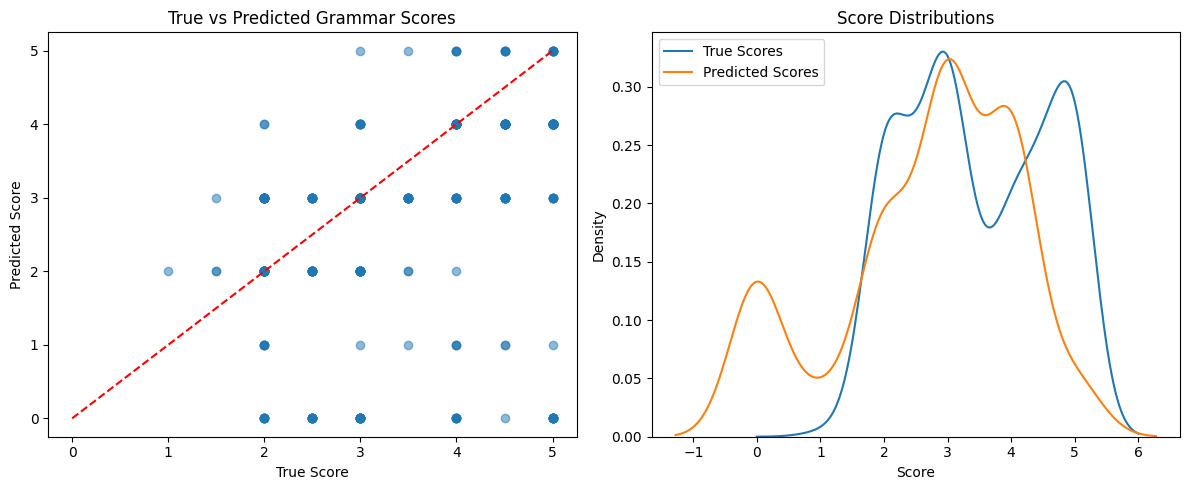

In [11]:
# Load and process training data
train_df = pd.read_csv('dataset/train.csv')
train_results = process_dataset(train_df, TRAIN_AUDIO_PATH)

# Calculate metrics if we have true scores
if 'true_score' in train_results.columns:
    mse = mean_squared_error(train_results['true_score'], train_results['predicted_score'])
    r2 = r2_score(train_results['true_score'], train_results['predicted_score'])

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R² Score: {r2:.4f}')

    # Plot results
    plt.figure(figsize=(12, 5))

    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(train_results['true_score'], train_results['predicted_score'], alpha=0.5)
    plt.plot([0, 5], [0, 5], 'r--')
    plt.xlabel('True Score')
    plt.ylabel('Predicted Score')
    plt.title('True vs Predicted Grammar Scores')

    # Distribution plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=train_results, x='true_score', label='True Scores')
    sns.kdeplot(data=train_results, x='predicted_score', label='Predicted Scores')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Score Distributions')
    plt.legend()

    plt.tight_layout()
    plt.show()



## Predictions and Submission

In [10]:
def process_audio_file(file_path):
    """Process a single audio file through transcription and grammar analysis"""
    # First, transcribe the audio
    transcription = transcribe_audio(file_path)
    if transcription is None:
        return None

    
    analysis = analyze_grammar(transcription)
    if analysis is None:
        return None

    return analysis

def process_dataset(df, audio_path):
    """Process entire dataset and return results in submission format"""
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio files"):
        file_path = os.path.join(audio_path, row['filename'])

        # Process audio file
        analysis = process_audio_file(file_path)
        if analysis is None:
            # If processing fails, use a default score of 0
            result = {
                'filename': row['filename'],
                'label': 0
            }
        else:
            result = {
                'filename': row['filename'],
                'label': analysis['score']
            }

        results.append(result)

        # Save intermediate results
        if len(results) % 10 == 0:
            pd.DataFrame(results).to_csv('test_output.csv', index=False)

    # Convert to DataFrame and ensure correct column names
    results_df = pd.DataFrame(results)
    results_df = results_df[['filename', 'label']] 
    
    return results_df

# Example usage for test data
test_df = pd.read_csv('dataset/test.csv')
test_results = process_dataset(test_df, TEST_AUDIO_PATH)

# Save results in submission format
test_results.to_csv('submission.csv', index=False)

Processing audio files:   0%|          | 0/195 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/audio/transcriptions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Requ